# Скачаем датасет данных с Twitter Sentiment

In [1]:
! mkdir -p /home/jovyan/data
! mkdir -p /home/jovyan/models

In [2]:
! wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip -O /home/jovyan/data/sentiment.zip

--2020-01-19 18:57:43--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2020-01-19 18:57:43--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘/home/jovyan/data/sentiment.zip’

/home/jovyan/data/s 100%[===================>]  77.59M   127KB/s    in 16m 31s 

2020-01-19 19:14:15 (80.2 KB/s) - ‘/home/jovyan/data/sentiment.zip’ saved [81363704/81363704]



In [3]:
! cd /home/jovyan/data && unzip sentiment.zip

Archive:  sentiment.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [4]:
! ls -la /home/jovyan/data

total 312760
drwxr-sr-x 2 jovyan users      4096 Jan 19 19:46 .
drwsrwsr-x 1 jovyan users      4096 Jan 19 19:14 ..
-rw-r--r-- 1 jovyan users  81363704 Apr 22  2012 sentiment.zip
-rw-r--r-- 1 jovyan users     74326 Mar  4  2010 testdata.manual.2009.06.14.csv
-rw-r--r-- 1 jovyan users 238803811 Mar  4  2010 training.1600000.processed.noemoticon.csv


In [5]:
! head -n 5 /home/jovyan/data/training.1600000.processed.noemoticon.csv

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"
"0","1467810917","Mon Apr 06 22:19:53 PDT 2009","NO_QUERY","mattycus","@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds"
"0","1467811184","Mon Apr 06 22:19:57 PDT 2009","NO_QUERY","ElleCTF","my whole body feels itchy and like its on fire "
"0","1467811193","Mon Apr 06 22:19:57 PDT 2009","NO_QUERY","Karoli","@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "


# Читаем датасет с помощью Spark

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('twitter-sentiment').getOrCreate()

print("Spark context started")

Spark context started


In [7]:
from pyspark.sql.types import StructType, StructField, IntegerType, LongType, StringType

schema = StructType([
    StructField("target", IntegerType(), True),
    StructField("id", LongType(), True),
    StructField("raw_timestamp", StringType(), True),
    StructField("query_status", StringType(), True),
    StructField("author", StringType(), True),
    StructField("tweet", StringType(), True)
])
    
data_path = "/home/jovyan/data/training.1600000.processed.noemoticon.csv"

raw_sentiment = spark.read.csv(data_path,header=False,schema=schema) \
    .selectExpr("(case when target=4 then 1 else 0 end) as target","tweet")



raw_sentiment.groupBy("target").count().show()

+------+------+
|target| count|
+------+------+
|     1|800000|
|     0|800000|
+------+------+



In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
raw_sentiment_sample = raw_sentiment.sample(fraction=0.005,withReplacement=False,seed=42).toPandas()
X, y = raw_sentiment_sample["tweet"], raw_sentiment_sample["target"]

print("Dataset size is: %i" % X.size)


Dataset size is: 8073


In [11]:
from sklearn.model_selection import GridSearchCV
from time import time
from pprint import pprint

from sentiment_model import pipeline, parameters

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, cv=3,
                               n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X, y)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__max_depth': (5, 8),
 'clf__n_estimators': (40, 60, 100),
 'tfidf__max_df': (0.5, 0.75, 1.0)}
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.3min finished


done in 81.210s

Best score: 0.667
Best parameters set:
	clf__max_depth: 8
	clf__n_estimators: 100
	tfidf__max_df: 0.5


In [16]:
import pickle as pkl

def save_model(model,model_path):
    with open(model_path,'wb') as buffer:
        pkl.dump(model,buffer)

def read_model(model_path):
    with open(model_path,'rb') as buffer:
        return pkl.load(buffer)

model_path = "/home/jovyan/tweet_sentiment.mdl"
save_model(grid_search.best_estimator_,model_path)

In [13]:
model_object = read_model(model_path)
model_object

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=<function preprocessor at 0x7f38c3990a60>,
                                 smooth_idf=True, stop_words=None,
                                 strip_accents=None,...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=8,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,

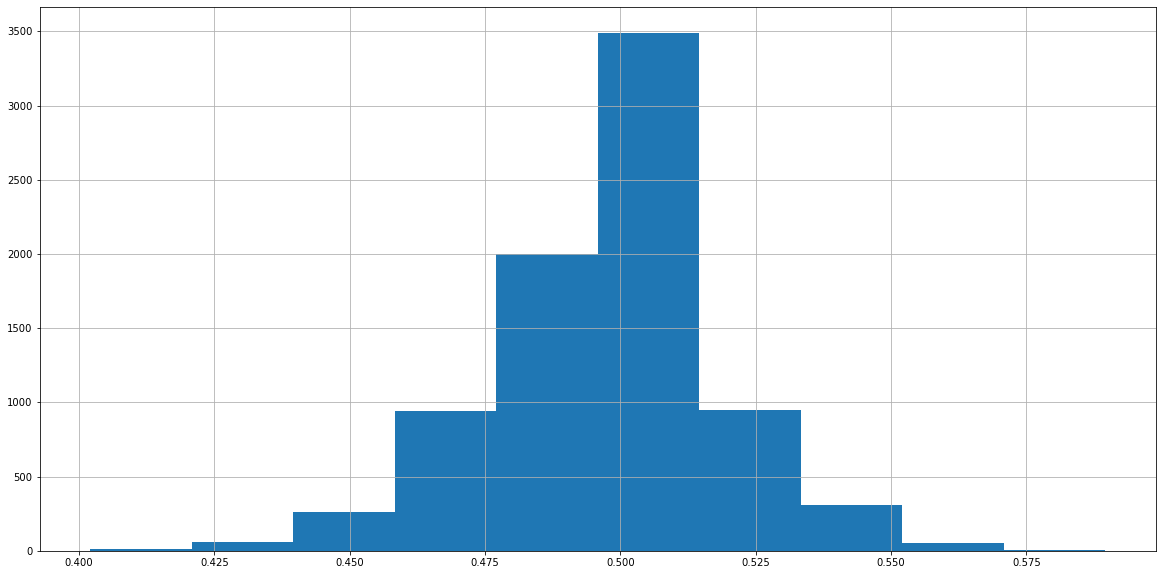

In [14]:
%matplotlib inline
import pandas as pd

pd.Series(model_object.predict_proba(X)[:,1]).hist(figsize=(20,10))

In [15]:
spark.stop()